In [1]:
def allmetrics(pred):
    metrics=["accuracy","f1","recallByLabel","precisionByLabel"]
    for m in metrics:
        ev= MulticlassClassificationEvaluator(labelCol="firstwin_otherlose",predictionCol="prediction",metricName=m)
        if m=="accuracy":
            accuracy=ev.evaluate(pred)
            continue
        elif m=="f1":
            f1=ev.evaluate(pred)
            continue
        elif m=="recallByLabel":
            recall=ev.evaluate(pred)
            continue
        else:
            precision=ev.evaluate(pred)
    return """Accuracy is: %s\nTest Error is = %s\nF1score is: %s\nRecall is %s\nPrecision is: %s """ % (accuracy,(1.0 - accuracy),f1,recall,precision)    

In [2]:
def count_nulls(sparkdf):#input pyspark df, return a list with nan and relative value
    null_counts=[]
    for col in sparkdf.dtypes:
        thename = col[0]
        thetype = col[1]
        nulls = sparkdf.where(sparkdf[thename].isNull()).count()
        result =tuple([thename,nulls])
        null_counts.append(result)
    null_counts=[(x,y) for (x.y) in null_counts if y!=0]
    return null_counts

In [3]:
import csv 
import io
import pyspark
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import ast
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf, lit
from pyspark.sql.types import LongType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pyspark.sql.functions import col

# Data processing

In [4]:
#conf = pyspark.SparkConf().setMaster("local[*]").setAppName("My App")
#sc = pyspark.SparkContext(conf = conf)
#sqlContext = SQLContext(sc)
#spark = SparkSession.builder.getOrCreate()

# Ci fa andare OUT OF MEMORY

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('My App') \
    .getOrCreate()

### Load units

In [6]:
df=pd.read_csv('data_full_encoded_units.csv', index_col=0).reset_index()

df_schema = StructType([StructField("index", StringType(), True),
                        StructField("levels", IntegerType(), True),
                        StructField("units_lst", StringType(), True)])

dfs = spark.createDataFrame(df, schema=df_schema)

df_pivot=dfs.groupBy("index").pivot("units_lst").sum("levels")

df_pivot.printSchema()

/usr/lib/python3/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


root
 |-- index: string (nullable = true)
 |-- Aatrox: long (nullable = true)
 |-- Ahri: long (nullable = true)
 |-- Akali: long (nullable = true)
 |-- Annie: long (nullable = true)
 |-- Aphelios: long (nullable = true)
 |-- Ashe: long (nullable = true)
 |-- Azir: long (nullable = true)
 |-- Cassiopeia: long (nullable = true)
 |-- Diana: long (nullable = true)
 |-- Elise: long (nullable = true)
 |-- Evelynn: long (nullable = true)
 |-- Ezreal: long (nullable = true)
 |-- Fiora: long (nullable = true)
 |-- Garen: long (nullable = true)
 |-- Hecarim: long (nullable = true)
 |-- Irelia: long (nullable = true)
 |-- Janna: long (nullable = true)
 |-- JarvanIV: long (nullable = true)
 |-- Jax: long (nullable = true)
 |-- Jhin: long (nullable = true)
 |-- Jinx: long (nullable = true)
 |-- Kalista: long (nullable = true)
 |-- Katarina: long (nullable = true)
 |-- Kayn: long (nullable = true)
 |-- Kennen: long (nullable = true)
 |-- Kindred: long (nullable = true)
 |-- LeeSin: long (nullable = 

In [7]:
#df_pivot.show(3)

### Load traits

In [8]:
df=pd.read_csv('data_full_encoded_traits.csv', index_col=0).reset_index()

df_schema = StructType([StructField("index", StringType(), True),
                        StructField("traits_level", IntegerType(), True),
                        StructField("traits_lst", StringType(), True)])

dfs = spark.createDataFrame(df, schema=df_schema)

df_pivot2=dfs.groupBy("index").pivot("traits_lst").sum("traits_level")

df_pivot2.printSchema()

root
 |-- index: string (nullable = true)
 |-- Adept: long (nullable = true)
 |-- Assassin: long (nullable = true)
 |-- Boss: long (nullable = true)
 |-- Brawler: long (nullable = true)
 |-- Cultist: long (nullable = true)
 |-- Dazzler: long (nullable = true)
 |-- Divine: long (nullable = true)
 |-- Duelist: long (nullable = true)
 |-- Dusk: long (nullable = true)
 |-- Elderwood: long (nullable = true)
 |-- Emperor: long (nullable = true)
 |-- Enlightened: long (nullable = true)
 |-- Exile: long (nullable = true)
 |-- Fortune: long (nullable = true)
 |-- Hunter: long (nullable = true)
 |-- Keeper: long (nullable = true)
 |-- Mage: long (nullable = true)
 |-- Moonlight: long (nullable = true)
 |-- Mystic: long (nullable = true)
 |-- NaN: long (nullable = true)
 |-- Ninja: long (nullable = true)
 |-- Shade: long (nullable = true)
 |-- Sharpshooter: long (nullable = true)
 |-- Spirit: long (nullable = true)
 |-- Tormented: long (nullable = true)
 |-- Vanguard: long (nullable = true)
 |-- 

In [9]:
#df_pivot2.show(3)

### Load data

In [10]:
data=pd.read_csv('data_modificato.csv', index_col=0).reset_index()

df_schema = StructType([StructField("index", StringType(), True),
                        StructField("patch_version", StringType(), True),
                        StructField("match_id", StringType(), True),
                        StructField("puuid", StringType(), True),
                        StructField("placement", IntegerType(), True),
                        StructField("level", IntegerType(), True),
                        StructField("gold_left", IntegerType(), True),
                        StructField("last_round", IntegerType(), True),
                        StructField("time_in_game", FloatType(), True),
                        StructField("total_dmg_to_players", IntegerType(), True),
                        StructField("players_eliminated", IntegerType(), True),
                        StructField("chosen_unit", StringType(), True),
                        StructField("chosen_trait", StringType(), True),
                        StructField("units", StringType(), True),
                        StructField("traits", StringType(), True),
                        StructField("units_lst", StringType(), True),
                        StructField("levels", StringType(), True),
                        StructField("traits_lst", StringType(), True),
                        StructField("traits_level", StringType(), True)])

data_spark = spark.createDataFrame(data, schema=df_schema)
data_spark.printSchema()

root
 |-- index: string (nullable = true)
 |-- patch_version: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- puuid: string (nullable = true)
 |-- placement: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- gold_left: integer (nullable = true)
 |-- last_round: integer (nullable = true)
 |-- time_in_game: float (nullable = true)
 |-- total_dmg_to_players: integer (nullable = true)
 |-- players_eliminated: integer (nullable = true)
 |-- chosen_unit: string (nullable = true)
 |-- chosen_trait: string (nullable = true)
 |-- units: string (nullable = true)
 |-- traits: string (nullable = true)
 |-- units_lst: string (nullable = true)
 |-- levels: string (nullable = true)
 |-- traits_lst: string (nullable = true)
 |-- traits_level: string (nullable = true)



In [11]:
data_spark=data_spark.drop('units', 'traits', 'units_lst', 'levels', 'traits_lst', 'traits_level')

In [12]:
#data_spark.show(3)

Merge datasets

In [13]:
data_final=data_spark.join(df_pivot, on='index')
data_final=data_final.join(df_pivot2, on='index')

In [14]:
data_final=data_final.drop('NaN')
data_final.printSchema()

root
 |-- index: string (nullable = true)
 |-- patch_version: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- puuid: string (nullable = true)
 |-- placement: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- gold_left: integer (nullable = true)
 |-- last_round: integer (nullable = true)
 |-- time_in_game: float (nullable = true)
 |-- total_dmg_to_players: integer (nullable = true)
 |-- players_eliminated: integer (nullable = true)
 |-- chosen_unit: string (nullable = true)
 |-- chosen_trait: string (nullable = true)
 |-- Aatrox: long (nullable = true)
 |-- Ahri: long (nullable = true)
 |-- Akali: long (nullable = true)
 |-- Annie: long (nullable = true)
 |-- Aphelios: long (nullable = true)
 |-- Ashe: long (nullable = true)
 |-- Azir: long (nullable = true)
 |-- Cassiopeia: long (nullable = true)
 |-- Diana: long (nullable = true)
 |-- Elise: long (nullable = true)
 |-- Evelynn: long (nullable = true)
 |-- Ezreal: long (nullable = true)
 |-- Fio

In [15]:
#data_final.show(3)

# Bisogna modificare PLACEMENT per le diverse task di classificazione

In [16]:
from pyspark.sql.functions import when
from pyspark.sql.functions import lit

data_final=data_final.withColumn("firstwin_otherlose", when((data_final.placement==1), lit(1)).otherwise(lit(0)))#binary
#data_final=data_final.withColumn("win1_2_3_same", when((data_final.placement==1), lit(1)).when((data_final.placement==2), lit(1)).when((data_final.placement==3), lit(1)).otherwise(lit(0)))#(1 per primo secondo e terzo, 0 per le altre)
#data_final=data_final.withColumn("win1_2_3_different", when((data_final.placement==1), lit(1)).when((data_final.placement==2), lit(2)).when((data_final.placement==3), lit(3)).otherwise(lit(0)))#(1 per primo, 2 per secondo, 3 per terzo, 0 per le altre)

# FEATURE ENGINEERING

# Handling NaN and Null values

In [17]:
data_final_clean = data_final.replace(float('NaN'), None)
#data_final_clean.show()

In [18]:
#data_final_clean.show(3)

In [19]:
data_final_clean = data_final_clean.na.fill(value=0) #replacing all null values with 0
#data_final_clean.show(3)

In [20]:
data_class = data_final_clean.drop('index','patch_version', 'match_id', 'puuid','chosen_unit','chosen_trait','time_in_game','players_eliminated','players_eliminated', 'last_round','total_dmg_to_players','placement')

In [21]:
cols_in = [col for col in data_class.columns if col != 'firstwin_otherlose' ]

assembler = VectorAssembler(inputCols=cols_in, outputCol="features")

output_data_class = assembler.transform(data_class)
output_data_class.select("features", "firstwin_otherlose").show(truncate=True)

+--------------------+------------------+
|            features|firstwin_otherlose|
+--------------------+------------------+
|(86,[0,1,4,10,24,...|                 0|
|(86,[0,1,9,21,22,...|                 0|
|(86,[0,1,2,3,5,9,...|                 0|
|(86,[0,7,13,16,31...|                 0|
|(86,[0,1,2,8,9,26...|                 1|
|(86,[0,1,2,3,8,9,...|                 0|
|(86,[0,1,5,17,18,...|                 1|
|(86,[0,4,24,26,38...|                 0|
|(86,[0,1,2,8,9,18...|                 1|
|(86,[0,1,7,25,28,...|                 1|
|(86,[0,1,17,20,23...|                 0|
|(86,[0,2,9,21,29,...|                 0|
|(86,[0,1,14,20,23...|                 0|
|(86,[0,7,17,18,20...|                 0|
|(86,[0,1,2,9,21,2...|                 0|
|(86,[0,1,9,21,25,...|                 1|
|(86,[0,4,17,18,32...|                 0|
|(86,[0,8,18,21,22...|                 0|
|(86,[0,1,17,20,23...|                 1|
|(86,[0,1,8,21,22,...|                 0|
+--------------------+------------

In [22]:
output_data_class.groupBy('firstwin_otherlose').count().orderBy('count').show()

+------------------+------+
|firstwin_otherlose| count|
+------------------+------+
|                 1| 93616|
|                 0|655312|
+------------------+------+



Si tratta di un dataset sbilanciato, occore eseguire un undersampling sulla classe maggioritaria

## Undersampling

## Stratified sampling to obtain train-test 

(since we are umbalanced setting, with randomSplit() we risks to have very few or no 1(minority class) in testData

In [23]:
trainingData = output_data_class.sampleBy("firstwin_otherlose", fractions={0: 0.7, 1: 0.7}, seed=0)
testData = output_data_class.subtract(trainingData)

In [24]:
trainingData.groupBy("firstwin_otherlose").count().show()

+------------------+------+
|firstwin_otherlose| count|
+------------------+------+
|                 1| 65748|
|                 0|458087|
+------------------+------+



In [25]:
testData.groupBy("firstwin_otherlose").count().show()

+------------------+------+
|firstwin_otherlose| count|
+------------------+------+
|                 1| 26917|
|                 0|180676|
+------------------+------+



In [26]:
from pyspark.sql.functions import col
major_df = trainingData.filter(col("firstwin_otherlose") == 0)
minor_df = trainingData.filter(col("firstwin_otherlose") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 6


In [27]:
sampled_majority_df = trainingData.sample(False, 1/ratio)
trainingData = sampled_majority_df.unionAll(minor_df)
trainingData.show()

+-----+---------+------+----+-----+-----+--------+----+----+----------+-----+-----+-------+------+-----+-----+-------+------+-----+--------+---+----+----+-------+--------+----+------+-------+------+------+---------+----+---+------+-------+----+-------+----+----+-----+-------+----+----+-----+---------+-----+-----+------+-----------+-----+------+---+-------+------+-------+-----+----+-----+---+------+-----+--------+----+-------+-------+-------+------+-------+----+---------+-------+-----------+-----+-------+------+------+----+---------+------+-----+-----+------------+------+---------+--------+-------+------------------+--------------------+
|level|gold_left|Aatrox|Ahri|Akali|Annie|Aphelios|Ashe|Azir|Cassiopeia|Diana|Elise|Evelynn|Ezreal|Fiora|Garen|Hecarim|Irelia|Janna|JarvanIV|Jax|Jhin|Jinx|Kalista|Katarina|Kayn|Kennen|Kindred|LeeSin|Lillia|Lissandra|Lulu|Lux|Maokai|Morgana|Nami|Nidalee|Nunu|Pyke|Riven|Sejuani|Sett|Shen|Sylas|TahmKench|Talon|Teemo|Thresh|TwistedFate|Vayne|Veigar| Vi|Warwi

In [28]:
trainingData.groupBy("firstwin_otherlose").count().show()

+------------------+-----+
|firstwin_otherlose|count|
+------------------+-----+
|                 1|76518|
|                 0|76452|
+------------------+-----+



In [29]:
testData.groupBy("firstwin_otherlose").count().show()

+------------------+------+
|firstwin_otherlose| count|
+------------------+------+
|                 1| 26917|
|                 0|180676|
+------------------+------+



## Classification

## Random Forest

### RF without hyper-parameter tuning

In [30]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="firstwin_otherlose", featuresCol="features", numTrees=10)  #costruisco l'istanza del classifier

# Train model.  This also runs the indexers.  #fit per allenare il modello sil train
rf = rf.fit(trainingData)    

### Predict on training

In [31]:
# Make predictions.
predictiontrain = rf.transform(trainingData)    #transform per applicare il modello sul test dataF


predictiontrain.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)
#predictions.show(truncate=False)        #label iniziale, features del dato,  
#raw prediction (predizione fatta) ad ogni prediziione è associato livello di probabilità 
#prediction finale fatta dal modello

+------------------+--------------------+--------------------+--------------------+----------+
|firstwin_otherlose|            features|       rawPrediction|         probability|prediction|
+------------------+--------------------+--------------------+--------------------+----------+
|                 0|(86,[0,1,17,20,23...|[3.04659933454947...|[0.30465993345494...|       1.0|
|                 0|(86,[0,1,14,20,23...|[6.24893377534842...|[0.62489337753484...|       0.0|
|                 0|(86,[0,7,17,18,20...|[7.93921945747424...|[0.79392194574742...|       0.0|
|                 1|(86,[0,1,17,20,23...|[5.49055951267474...|[0.54905595126747...|       0.0|
|                 0|(86,[0,1,8,21,22,...|[5.69102295867288...|[0.56910229586728...|       0.0|
|                 0|(86,[0,4,10,17,38...|[8.06788646005581...|[0.80678864600558...|       0.0|
|                 0|(86,[0,1,7,13,16,...|[4.93519112881425...|[0.49351911288142...|       1.0|
|                 1|(86,[0,1,6,10,17,...|[5.490559

In [32]:
print(allmetrics(predictiontrain))

Accuracy is: 0.7895043007660331
Test Error is = 0.21049569923396694
F1score is: 0.7893535191762145
Recall is 0.8167417260159195
Precision is: 0.7740870795230355 


### Predict on test

In [33]:
# Make predictions.
predictions = rf.transform(testData)    #transform per applicare il modello sul test dataF


predictions.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)
#predictions.show(truncate=False)        #label iniziale, features del dato,  
#raw prediction (predizione fatta) ad ogni prediziione è associato livello di probabilità 
#prediction finale fatta dal modello

+------------------+--------------------+--------------------+--------------------+----------+
|firstwin_otherlose|            features|       rawPrediction|         probability|prediction|
+------------------+--------------------+--------------------+--------------------+----------+
|                 0|(86,[0,1,2,8,15,1...|[5.69102295867288...|[0.56910229586728...|       0.0|
|                 0|(86,[0,1,2,9,11,2...|[3.41571846422048...|[0.34157184642204...|       1.0|
|                 0|(86,[0,1,2,8,15,2...|[2.97247706050838...|[0.29724770605083...|       1.0|
|                 0|(86,[0,7,16,17,27...|[6.39043652392631...|[0.63904365239263...|       0.0|
|                 0|(86,[0,1,17,18,27...|[5.88329732273652...|[0.58832973227365...|       0.0|
|                 0|(86,[0,1,7,25,33,...|[6.32343366390913...|[0.63234336639091...|       0.0|
|                 0|(86,[0,1,9,13,17,...|[5.69346876166064...|[0.56934687616606...|       0.0|
|                 0|(86,[0,7,13,17,20...|[6.403921

In [34]:
evaluatorrftest = BinaryClassificationEvaluator(labelCol="firstwin_otherlose",rawPredictionCol="prediction",metricName="areaUnderROC")#la label column è nella colonna label
print("AUC ROC = " + str(evaluatorrftest.evaluate(predictions)))
print(allmetrics(predictions))

AUC ROC = 0.7859148823090554
Accuracy is: 0.8017226014364646
Test Error is = 0.19827739856353543
F1score is: 0.8275449161016137
Recall is 0.8072571896654785
Precision is: 0.9583609853537378 


In [35]:
predictions.groupBy("firstwin_otherlose", "prediction").count().show(10)

+------------------+----------+------+
|firstwin_otherlose|prediction| count|
+------------------+----------+------+
|                 1|       0.0|  6337|
|                 0|       0.0|145852|
|                 1|       1.0| 20580|
|                 0|       1.0| 34824|
+------------------+----------+------+



In [37]:
TN = predictions.filter('prediction = 0 AND firstwin_otherlose = prediction').count()
TP = predictions.filter('prediction = 1 AND firstwin_otherlose = prediction').count()
FN = predictions.filter('prediction = 0 AND firstwin_otherlose = 1').count()
FP = predictions.filter('prediction = 1 AND firstwin_otherlose = 0').count()
data2 = [("class 1 actual",TP,FN),
    ("class 0 actual",FP,TN),
  ]
schema = StructType([ \
    StructField("",StringType(),True), \
    StructField("Class 1 pred",IntegerType(),True), \
    StructField("Class 0 pred",IntegerType(),True), \
  ])
confusion_matrix= spark.createDataFrame(data=data2,schema=schema)
confusion_matrix.printSchema()
confusion_matrix.show(truncate=False)
print("TP: ",TP,"FN: ",FP,"TN: ",TN,"FP: ",FN)

root
 |-- : string (nullable = true)
 |-- Class 1 pred: integer (nullable = true)
 |-- Class 0 pred: integer (nullable = true)

+--------------+------------+------------+
|              |Class 1 pred|Class 0 pred|
+--------------+------------+------------+
|class 1 actual|20580       |6337        |
|class 0 actual|34824       |145852      |
+--------------+------------+------------+

TP:  20580 FN:  34824 TN:  145852 FP:  6337


## RF with hyper-parameter tuning

In [38]:
numFolds = 5

rf = RandomForestClassifier(labelCol="firstwin_otherlose", featuresCol="features")
evaluator = BinaryClassificationEvaluator(labelCol="firstwin_otherlose"     #la label column è nella colonna label
                                              , rawPredictionCol="prediction" #la prediction column è della colonna prediction
                                              , metricName="areaUnderROC") # + other params as in Scala    

pipeline = Pipeline(stages=[rf])
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10,15,20]).build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=numFolds,
    seed=0)

model_rf = crossval.fit(trainingData)

Best Model parameters

In [39]:
bestPipeline = model_rf.bestModel
bestModel = bestPipeline.stages[-1]

In [40]:
print('Optimal numTrees - ', bestModel.getNumTrees)
print('Optimal maxDepth - ', bestModel.getOrDefault('maxDepth'))

Optimal numTrees -  10
Optimal maxDepth -  5


### Predict on training

In [41]:
predictions_gridtrain = model_rf.transform(trainingData)
predictions_gridtrain.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)

+------------------+--------------------+--------------------+--------------------+----------+
|firstwin_otherlose|            features|       rawPrediction|         probability|prediction|
+------------------+--------------------+--------------------+--------------------+----------+
|                 0|(86,[0,1,17,20,23...|[3.04659933454947...|[0.30465993345494...|       1.0|
|                 0|(86,[0,1,14,20,23...|[6.24893377534842...|[0.62489337753484...|       0.0|
|                 0|(86,[0,7,17,18,20...|[7.93921945747424...|[0.79392194574742...|       0.0|
|                 1|(86,[0,1,17,20,23...|[5.49055951267474...|[0.54905595126747...|       0.0|
|                 0|(86,[0,1,8,21,22,...|[5.69102295867288...|[0.56910229586728...|       0.0|
|                 0|(86,[0,4,10,17,38...|[8.06788646005581...|[0.80678864600558...|       0.0|
|                 0|(86,[0,1,7,13,16,...|[4.93519112881425...|[0.49351911288142...|       1.0|
|                 1|(86,[0,1,6,10,17,...|[5.490559

In [42]:
print(allmetrics(predictions_gridtrain))

Accuracy is: 0.7895043007660331
Test Error is = 0.21049569923396694
F1score is: 0.7893535191762145
Recall is 0.8167417260159195
Precision is: 0.7740870795230355 


### Predict on test

In [43]:
predictions_grid = model_rf.transform(testData)
predictions_grid.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)

+------------------+--------------------+--------------------+--------------------+----------+
|firstwin_otherlose|            features|       rawPrediction|         probability|prediction|
+------------------+--------------------+--------------------+--------------------+----------+
|                 0|(86,[0,1,2,8,15,1...|[5.69102295867288...|[0.56910229586728...|       0.0|
|                 0|(86,[0,1,2,9,11,2...|[3.41571846422048...|[0.34157184642204...|       1.0|
|                 0|(86,[0,1,2,8,15,2...|[2.97247706050838...|[0.29724770605083...|       1.0|
|                 0|(86,[0,7,16,17,27...|[6.39043652392631...|[0.63904365239263...|       0.0|
|                 0|(86,[0,1,17,18,27...|[5.88329732273652...|[0.58832973227365...|       0.0|
|                 0|(86,[0,1,7,25,33,...|[6.32343366390913...|[0.63234336639091...|       0.0|
|                 0|(86,[0,1,9,13,17,...|[5.69346876166064...|[0.56934687616606...|       0.0|
|                 0|(86,[0,7,13,17,20...|[6.403921

In [44]:
evaluatorrftesthp = BinaryClassificationEvaluator(labelCol="firstwin_otherlose",rawPredictionCol="prediction",metricName="areaUnderROC")#la label column è nella colonna label
print("AUC ROC = " + str(evaluatorrftesthp.evaluate(predictions_grid)))
print(allmetrics(predictions_grid ))

AUC ROC = 0.7859148823090554
Accuracy is: 0.8017226014364646
Test Error is = 0.19827739856353543
F1score is: 0.8275449161016137
Recall is 0.8072571896654785
Precision is: 0.9583609853537378 


In [45]:
predictions_grid.groupBy("firstwin_otherlose", "prediction").count().show(10)

+------------------+----------+------+
|firstwin_otherlose|prediction| count|
+------------------+----------+------+
|                 1|       0.0|  6337|
|                 0|       0.0|145852|
|                 1|       1.0| 20580|
|                 0|       1.0| 34824|
+------------------+----------+------+



In [46]:
TN = predictions_grid.filter('prediction = 0 AND firstwin_otherlose = prediction').count()
TP = predictions_grid.filter('prediction = 1 AND firstwin_otherlose = prediction').count()
FN = predictions_grid.filter('prediction = 0 AND firstwin_otherlose = 1').count()
FP = predictions_grid.filter('prediction = 1 AND firstwin_otherlose = 0').count()
data2 = [("class 1 actual",TP,FN),
    ("class 0 actual",FP,TN),
  ]
schema = StructType([ \
    StructField("",StringType(),True), \
    StructField("Class 1 pred",IntegerType(),True), \
    StructField("Class 0 pred",IntegerType(),True), \
  ])
confusion_matrix= spark.createDataFrame(data=data2,schema=schema)
confusion_matrix.printSchema()
confusion_matrix.show(truncate=False)
print("TP: ",TP,"FN: ",FP,"TN: ",TN,"FP: ",FN)

root
 |-- : string (nullable = true)
 |-- Class 1 pred: integer (nullable = true)
 |-- Class 0 pred: integer (nullable = true)

+--------------+------------+------------+
|              |Class 1 pred|Class 0 pred|
+--------------+------------+------------+
|class 1 actual|20580       |6337        |
|class 0 actual|34824       |145852      |
+--------------+------------+------------+

TP:  20580 FN:  34824 TN:  145852 FP:  6337


## Explanation on RF

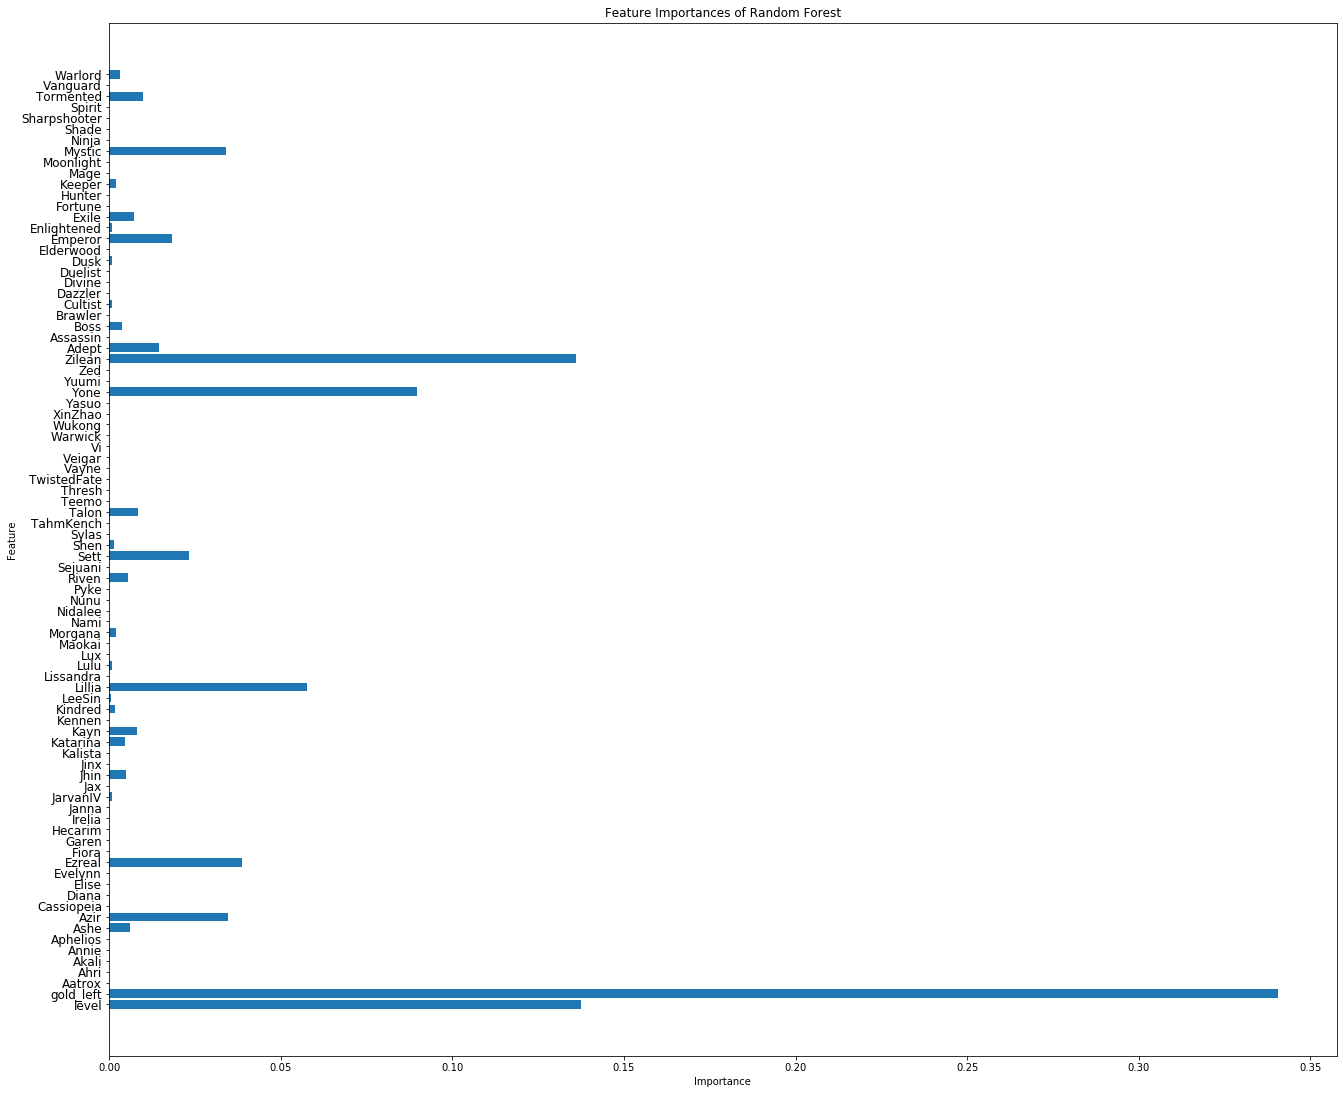

In [47]:
importances = bestModel.featureImportances
y_values = list(range(len(importances)))
plt.barh(y_values, importances)
plt.yticks(y_values, cols_in, rotation=0, fontsize=12)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest')
plt.gcf().set_size_inches(22,19)

# Multilayer Perceptron (ANN)

In [48]:
layers = [86, 68, 32, 2]

# create the trainer and set its parameters
mlp = MultilayerPerceptronClassifier(labelCol="firstwin_otherlose", featuresCol="features",predictionCol='prediction', maxIter=10, layers=layers, blockSize=128, seed=0)

# train the model
model_mlp = mlp.fit(trainingData)

### Prediction on training

In [49]:
# compute accuracy on the test set
predictionsmlptrain = model_mlp.transform(trainingData)
#predictionsmlptrain.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)

In [50]:
predictionsmlptrain.groupBy("firstwin_otherlose", "prediction").count().show(10)

+------------------+----------+-----+
|firstwin_otherlose|prediction|count|
+------------------+----------+-----+
|                 1|       0.0|20004|
|                 0|       0.0|48442|
|                 1|       1.0|56608|
|                 0|       1.0|27942|
+------------------+----------+-----+



In [51]:
evaluatormlptrain = BinaryClassificationEvaluator(labelCol="firstwin_otherlose",rawPredictionCol="prediction",metricName="areaUnderROC")#la label column è nella colonna label
print("AUC ROC = " + str(evaluatormlptrain.evaluate(predictionsmlptrain)))
print(allmetrics(predictionsmlptrain))

AUC ROC = 0.6865412429688029
Accuracy is: 0.6866192580198175
Test Error is = 0.3133807419801825
F1score is: 0.6857489527852071
Recall is 0.6341904063678258
Precision is: 0.7077404084972094 


### Prediction on test

In [52]:
# compute accuracy on the test set
predictionsmlptest = model_mlp.transform(testData)
#predictionsmlptest.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)

In [53]:
evaluatormlptest = BinaryClassificationEvaluator(labelCol="firstwin_otherlose",rawPredictionCol="prediction",metricName="areaUnderROC")#la label column è nella colonna label
print("AUC ROC = " + str(evaluatormlptest.evaluate(predictionsmlptest)))
print(allmetrics(predictionsmlptest))

AUC ROC = 0.6795160145564473
Accuracy is: 0.6324490710187723
Test Error is = 0.36755092898122765
F1score is: 0.6927484937598982
Recall is 0.6159700236888132
Precision is: 0.9414924666051926 


In [ ]:
predictionsmlptest.groupBy("firstwin_otherlose", "prediction").count().show(10)

In [54]:
TN = predictionsmlptest.filter('prediction = 0 AND firstwin_otherlose = prediction').count()
TP = predictionsmlptest.filter('prediction = 1 AND firstwin_otherlose = prediction').count()
FN = predictionsmlptest.filter('prediction = 0 AND firstwin_otherlose = 1').count()
FP = predictionsmlptest.filter('prediction = 1 AND firstwin_otherlose = 0').count()
data2 = [("class 1 actual",TP,FN),
    ("class 0 actual",FP,TN),
  ]
schema = StructType([ \
    StructField("",StringType(),True), \
    StructField("Class 1 pred",IntegerType(),True), \
    StructField("Class 0 pred",IntegerType(),True), \
  ])
confusion_matrix= spark.createDataFrame(data=data2,schema=schema)
confusion_matrix.printSchema()
confusion_matrix.show(truncate=False)
print("TP: ",TP,"FN: ",FP,"TN: ",TN,"FP: ",FN)

root
 |-- : string (nullable = true)
 |-- Class 1 pred: integer (nullable = true)
 |-- Class 0 pred: integer (nullable = true)

+--------------+------------+------------+
|              |Class 1 pred|Class 0 pred|
+--------------+------------+------------+
|class 1 actual|20001       |6916        |
|class 0 actual|69385       |111291      |
+--------------+------------+------------+

TP:  20001 FN:  69385 TN:  111291 FP:  6916


## Multilayer Perceptron with hyper parameter tuning

In [55]:
numFolds = 5
mlphp = MultilayerPerceptronClassifier(labelCol="firstwin_otherlose", featuresCol="features",predictionCol='prediction', blockSize=128, seed=0)
evaluator = BinaryClassificationEvaluator(labelCol="firstwin_otherlose"     #la label column è nella colonna label
                                              , rawPredictionCol="prediction"
                                              , metricName="areaUnderROC")#la prediction column è della colonna prediction
pipeline = Pipeline(stages=[mlphp])
paramGrid = ParamGridBuilder().addGrid(mlphp.layers, [[86,48,2],[86,24,2]]).addGrid(mlphp.maxIter,[5,10,15]).build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=numFolds,
    seed=0)

model_mlphp = crossval.fit(trainingData)

In [56]:
bestPipeline = model_mlphp.bestModel
bestModel = bestPipeline.stages[-1]

In [57]:
print('Layers - ', bestModel.getOrDefault('layers'))
print('MaxIter - ', bestModel.getOrDefault('maxIter'))#('maxDepth')

Layers -  [86, 24, 2]
MaxIter -  15


### Prediction on training

In [115]:
# compute accuracy on the test set
predictionsmlphptrain = model_mlphp.transform(trainingData)
#predictionsmlptrain.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)

In [116]:
evaluatormlphptrain = BinaryClassificationEvaluator(labelCol="firstwin_otherlose",rawPredictionCol="prediction",metricName="areaUnderROC")#la label column è nella colonna label
print("AUC ROC = " + str(evaluatormlphptrain.evaluate(predictionsmlphptrain)))
print(allmetrics(predictionsmlphptrain))

AUC ROC = 0.740370029804097
Accuracy is: 0.7387189383025039
Test Error is = 0.2612810616974961
F1score is: 0.7399386828524601
Recall is 0.7288735632183908
Precision is: 0.7968574071095383 


### Prediction on test

In [58]:
# compute accuracy on the test set
predictionsmlphptest = model_mlphp.transform(testData)
#predictionsmlptest.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)

In [59]:
evaluatormlphptest = BinaryClassificationEvaluator(labelCol="firstwin_otherlose",rawPredictionCol="prediction",metricName="areaUnderROC")#la label column è nella colonna label
print("AUC ROC = " + str(evaluatormlphptest.evaluate(predictionsmlphptest)))
print(allmetrics(predictionsmlphptest))

AUC ROC = 0.7265178665206868
Accuracy is: 0.6910396786018796
Test Error is = 0.30896032139812035
F1score is: 0.7409732276688499
Recall is 0.6786180787708385
Precision is: 0.9528139133678369 


In [ ]:
predictionsmlphptest.groupBy("firstwin_otherlose", "prediction").count().show(10)

In [60]:
TN = predictionsmlphptest.filter('prediction = 0 AND firstwin_otherlose = prediction').count()
TP = predictionsmlphptest.filter('prediction = 1 AND firstwin_otherlose = prediction').count()
FN = predictionsmlphptest.filter('prediction = 0 AND firstwin_otherlose = 1').count()
FP = predictionsmlphptest.filter('prediction = 1 AND firstwin_otherlose = 0').count()
data2 = [("class 1 actual",TP,FN),
    ("class 0 actual",FP,TN),
  ]
schema = StructType([ \
    StructField("",StringType(),True), \
    StructField("Class 1 pred",IntegerType(),True), \
    StructField("Class 0 pred",IntegerType(),True), \
  ])
confusion_matrix= spark.createDataFrame(data=data2,schema=schema)
confusion_matrix.printSchema()
confusion_matrix.show(truncate=False)
print("TP: ",TP,"FN: ",FP,"TN: ",TN,"FP: ",FN)

root
 |-- : string (nullable = true)
 |-- Class 1 pred: integer (nullable = true)
 |-- Class 0 pred: integer (nullable = true)

+--------------+------------+------------+
|              |Class 1 pred|Class 0 pred|
+--------------+------------+------------+
|class 1 actual|20845       |6072        |
|class 0 actual|58066       |122610      |
+--------------+------------+------------+

TP:  20845 FN:  58066 TN:  122610 FP:  6072


## Logistic Regression

### Computing weights (non va)

In [62]:
#(trainingData, testData) = weightedDataset.randomSplit([0.7, 0.3],seed=0)
# create the trainer and set its parameters
lr = LogisticRegression(labelCol="firstwin_otherlose", featuresCol="features",predictionCol='prediction',)

# train the model
model_lr = lr.fit(trainingData)

### Predict on training

In [60]:
# Make predictions.
predictiontrainlr = model_lr.transform(trainingData)    #transform per applicare il modello sul test dataF
predictiontrainlr.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)

+------------------+--------------------+--------------------+--------------------+----------+
|firstwin_otherlose|            features|       rawPrediction|         probability|prediction|
+------------------+--------------------+--------------------+--------------------+----------+
|                 0|(86,[0,1,9,21,22,...|[-0.0046802789929...|[0.49882993238762...|       1.0|
|                 0|(86,[0,1,2,3,5,9,...|[-0.0046802789929...|[0.49882993238762...|       1.0|
|                 0|(86,[0,7,13,16,31...|[-0.0046802789929...|[0.49882993238762...|       1.0|
|                 0|(86,[0,1,2,3,8,9,...|[-0.0046802789929...|[0.49882993238762...|       1.0|
|                 1|(86,[0,1,5,17,18,...|[-0.0046802789929...|[0.49882993238762...|       1.0|
|                 0|(86,[0,4,24,26,38...|[-0.0046802789929...|[0.49882993238762...|       1.0|
|                 1|(86,[0,1,7,25,28,...|[-0.0046802789929...|[0.49882993238762...|       1.0|
|                 0|(86,[0,1,17,20,23...|[-0.00468

In [61]:
print("Coefficients: " + str(model_lr.coefficients))
print("Intercept: " + str(model_lr.intercept))
print(allmetrics(predictiontrainlr))

Coefficients: (86,[],[])
Intercept: 0.0046802789929492805
Accuracy is: 0.12551280460450331
Test Error is = 0.8744871953954967
F1score is: 0.027993398307403317
Recall is 0.0
Precision is: 0.0 


### Predict on test

In [63]:
# Make predictions.
predictionstestlr = model_lr.transform(testData)    #transform per applicare il modello sul test dataF
predictionstestlr.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)

+------------------+--------------------+--------------------+--------------------+----------+
|firstwin_otherlose|            features|       rawPrediction|         probability|prediction|
+------------------+--------------------+--------------------+--------------------+----------+
|                 0|(86,[0,1,2,8,15,1...|[0.91400971075312...|[0.71381997232303...|       0.0|
|                 0|(86,[0,1,2,9,11,2...|[-0.5935910454514...|[0.35581132659123...|       1.0|
|                 0|(86,[0,1,2,8,15,2...|[-2.2523627059683...|[0.09514585749664...|       1.0|
|                 0|(86,[0,7,16,17,27...|[4.11381687972667...|[0.98391760367685...|       0.0|
|                 0|(86,[0,1,17,18,27...|[2.90651055118482...|[0.94816733990334...|       0.0|
|                 0|(86,[0,1,7,25,33,...|[2.58541526474476...|[0.92991701198000...|       0.0|
|                 0|(86,[0,1,9,13,17,...|[0.31706793218944...|[0.57860951903131...|       0.0|
|                 0|(86,[0,7,13,17,20...|[3.231451

In [64]:
predictionstestlr.groupBy("firstwin_otherlose", "prediction").count().show(10)

+------------------+----------+------+
|firstwin_otherlose|prediction| count|
+------------------+----------+------+
|                 1|       0.0|  4677|
|                 0|       0.0|143421|
|                 1|       1.0| 22240|
|                 0|       1.0| 37255|
+------------------+----------+------+



In [65]:
print("Coefficients: " + str(model_lr.coefficients))
print("Intercept: " + str(model_lr.intercept))
print(allmetrics(predictionstestlr))

Coefficients: [0.9842809232248402,0.03172282223200971,0.7421612357810122,1.1233851841565932,0.674733655224771,0.9933885276958178,1.0482507598178195,0.9412451963226478,0.7806698790649098,0.6428621053630355,0.4388920182137914,0.8344058636611893,0.8411644640360849,0.967875051005028,0.5670528552779674,0.27128225532609834,0.37561592502996793,0.7932216457835826,0.8402619315059514,0.6783686074548744,0.5143470890915526,1.2523794117177542,1.3854456456577953,0.6361973528210005,1.1617861126163107,1.247445525787253,0.8870355966055177,1.0908691550220075,0.630837394360053,0.8752419825554447,0.6120731329905604,0.4448043373479494,0.6748829230151817,0.6000348058631323,1.0372383558262963,0.6032863797173837,0.5782586607873805,0.7139336362428578,0.7737200394908472,1.0110673453588257,1.1905854539167677,1.1102376394413167,0.8238644183016883,0.8085501081816494,1.053411359193439,1.199127411718888,0.9852721403549031,0.49199668520323053,0.5168904101546841,0.6644777320700582,0.7323505352584152,0.6671368907743679

In [66]:
evaluatorlrtest = BinaryClassificationEvaluator(labelCol="firstwin_otherlose",rawPredictionCol="prediction",metricName="areaUnderROC")#la label column è nella colonna label
print("AUC ROC = " + str(evaluatorlrtest.evaluate(predictionstestlr)))

AUC ROC = 0.8100229015257419


In [67]:
TN = predictionstestlr.filter('prediction = 0 AND firstwin_otherlose = prediction').count()
TP = predictionstestlr.filter('prediction = 1 AND firstwin_otherlose = prediction').count()
FN = predictionstestlr.filter('prediction = 0 AND firstwin_otherlose = 1').count()
FP = predictionstestlr.filter('prediction = 1 AND firstwin_otherlose = 0').count()
data2 = [("class 1 actual",TP,FN),
    ("class 0 actual",FP,TN),
  ]
schema = StructType([ \
    StructField("",StringType(),True), \
    StructField("Class 1 pred",IntegerType(),True), \
    StructField("Class 0 pred",IntegerType(),True), \
  ])
confusion_matrix= spark.createDataFrame(data=data2,schema=schema)
confusion_matrix.printSchema()
confusion_matrix.show(truncate=False)
print("TP: ",TP,"FN: ",FP,"TN: ",TN,"FP: ",FN)

root
 |-- : string (nullable = true)
 |-- Class 1 pred: integer (nullable = true)
 |-- Class 0 pred: integer (nullable = true)

+--------------+------------+------------+
|              |Class 1 pred|Class 0 pred|
+--------------+------------+------------+
|class 1 actual|22240       |4677        |
|class 0 actual|37255       |143421      |
+--------------+------------+------------+

TP:  22240 FN:  37255 TN:  143421 FP:  4677


## LR with hyper-parameter tuning

In [73]:
numFolds = 5

lr = LogisticRegression(labelCol="firstwin_otherlose", featuresCol="features")
evaluator = BinaryClassificationEvaluator(labelCol="firstwin_otherlose"     #la label column è nella colonna label
                                              , rawPredictionCol="prediction" #la prediction column è della colonna prediction
                                              , metricName="areaUnderROC") # + other params as in Scala    

pipeline = Pipeline(stages=[lr])
paramGrid = ParamGridBuilder().addGrid(lr.maxIter, [5,7,12]).addGrid(lr.regParam, [0.1,0.5]).addGrid(lr.elasticNetParam, [0.2,0.4]).build()
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=numFolds,
    seed=0)

model_lr = crossval.fit(trainingData)

Best Model parameters

In [74]:
bestPipeline = model_lr.bestModel
bestModel = bestPipeline.stages[-1]

In [78]:
print('Optimal maxIter - ', bestModel.getOrDefault('maxIter'))
print('Optimal regParam - ', bestModel.getOrDefault('regParam'))
print('Optimal elasticNetParam - ', bestModel.getOrDefault('elasticNetParam'))


Optimal maxIter -  12
Optimal regParam -  0.1
Optimal elasticNetParam -  0.2


### Predict on training

In [29]:
predictions_gridtrain = model_rf.transform(trainingData)
predictions_gridtrain.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)

+------------------+--------------------+--------------------+--------------------+----------+
|firstwin_otherlose|            features|       rawPrediction|         probability|prediction|
+------------------+--------------------+--------------------+--------------------+----------+
|                 0|(86,[0,1,49,54,67...|[13.8021774414229...|[0.69010887207114...|       0.0|
|                 0|(86,[0,6,7,10,17,...|[16.2765653585766...|[0.81382826792883...|       0.0|
|                 0|(86,[0,1,3,9,16,1...|[13.7016872175842...|[0.68508436087921...|       0.0|
|                 0|(86,[0,1,4,10,30,...|[13.8021774414229...|[0.69010887207114...|       0.0|
|                 0|(86,[0,1,10,24,30...|[13.8028029381561...|[0.69014014690780...|       0.0|
|                 0|(86,[0,1,4,61,79]...|[13.4690094222700...|[0.67345047111350...|       0.0|
|                 0|(86,[0,17,20,32,5...|[16.5623993202307...|[0.82811996601153...|       0.0|
|                 0|(86,[0,15,17,20,2...|[16.56239

In [30]:
print(allmetrics(predictions_gridtrain))

Accuracy is: 0.798179994892525
Test Error is = 0.201820005107475
F1score is: 0.7983394099439919
Recall is 0.800650892309334
Precision is: 0.7747147798255124 


### Predict on test

In [76]:
predictions_grid = model_rf.transform(testData)
predictions_grid.select('firstwin_otherlose','features','rawPrediction','probability','prediction').show(truncate=True)

+------------------+--------------------+--------------------+--------------------+----------+
|firstwin_otherlose|            features|       rawPrediction|         probability|prediction|
+------------------+--------------------+--------------------+--------------------+----------+
|                 0|(86,[0,1,2,8,15,1...|[5.69102295867288...|[0.56910229586728...|       0.0|
|                 0|(86,[0,1,2,9,11,2...|[3.41571846422048...|[0.34157184642204...|       1.0|
|                 0|(86,[0,1,2,8,15,2...|[2.97247706050838...|[0.29724770605083...|       1.0|
|                 0|(86,[0,7,16,17,27...|[6.39043652392631...|[0.63904365239263...|       0.0|
|                 0|(86,[0,1,17,18,27...|[5.88329732273652...|[0.58832973227365...|       0.0|
|                 0|(86,[0,1,7,25,33,...|[6.32343366390913...|[0.63234336639091...|       0.0|
|                 0|(86,[0,1,9,13,17,...|[5.69346876166064...|[0.56934687616606...|       0.0|
|                 0|(86,[0,7,13,17,20...|[6.403921

In [ ]:
predictions_grid.groupBy("firstwin_otherlose", "prediction").count().show(10)

In [80]:
evaluatorlrtest = BinaryClassificationEvaluator(labelCol="firstwin_otherlose",rawPredictionCol="prediction",metricName="areaUnderROC")#la label column è nella colonna label
#print("Coefficients: " + str(model_lr.coefficients))
#print("Intercept: " + str(model_lr.intercept))
print("AUC ROC = " + str(evaluatorlrtest.evaluate(predictions_grid)))
print(allmetrics(predictions_grid ))

AUC ROC = 0.7859148823090554
Accuracy is: 0.8017226014364646
Test Error is = 0.19827739856353543
F1score is: 0.8275449161016137
Recall is 0.8072571896654785
Precision is: 0.9583609853537378 


In [81]:
TN = predictions_grid.filter('prediction = 0 AND firstwin_otherlose = prediction').count()
TP = predictions_grid.filter('prediction = 1 AND firstwin_otherlose = prediction').count()
FN = predictions_grid.filter('prediction = 0 AND firstwin_otherlose = 1').count()
FP = predictions_grid.filter('prediction = 1 AND firstwin_otherlose = 0').count()
data2 = [("class 1 actual",TP,FN),
    ("class 0 actual",FP,TN),
  ]
schema = StructType([ \
    StructField("",StringType(),True), \
    StructField("Class 1 pred",IntegerType(),True), \
    StructField("Class 0 pred",IntegerType(),True), \
  ])
confusion_matrix= spark.createDataFrame(data=data2,schema=schema)
confusion_matrix.printSchema()
confusion_matrix.show(truncate=False)
print("TP: ",TP,"FN: ",FP,"TN: ",TN,"FP: ",FN)

root
 |-- : string (nullable = true)
 |-- Class 1 pred: integer (nullable = true)
 |-- Class 0 pred: integer (nullable = true)

+--------------+------------+------------+
|              |Class 1 pred|Class 0 pred|
+--------------+------------+------------+
|class 1 actual|20580       |6337        |
|class 0 actual|34824       |145852      |
+--------------+------------+------------+

TP:  20580 FN:  34824 TN:  145852 FP:  6337


## Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(labelCol='firstwin_otherlose',featuresCol='features')
#smoothing=1.0, modelType="multinomial"
# train the model
model_nb = nb.fit(trainingData)


# select example rows to display.
predictions_nb = model_nb.transform(testData)
predictions_nb.show(truncate=True)

evaluatornbtest = BinaryClassificationEvaluator(labelCol="firstwin_otherlose",rawPredictionCol="prediction",metricName="areaUnderROC")#la label column è nella colonna label
#print("Coefficients: " + str(model_lr.coefficients))
#print("Intercept: " + str(model_lr.intercept))
print("AUC ROC = " + str(evaluatornbtest.evaluate(predictions_nb)))
print(allmetrics(predictions_nb ))



+-----+---------+------+----+-----+-----+--------+----+----+----------+-----+-----+-------+------+-----+-----+-------+------+-----+--------+---+----+----+-------+--------+----+------+-------+------+------+---------+----+---+------+-------+----+-------+----+----+-----+-------+----+----+-----+---------+-----+-----+------+-----------+-----+------+---+-------+------+-------+-----+----+-----+---+------+-----+--------+----+-------+-------+-------+------+-------+----+---------+-------+-----------+-----+-------+------+------+----+---------+------+-----+-----+------------+------+---------+--------+-------+------------------+--------------------+--------------------+--------------------+----------+
|level|gold_left|Aatrox|Ahri|Akali|Annie|Aphelios|Ashe|Azir|Cassiopeia|Diana|Elise|Evelynn|Ezreal|Fiora|Garen|Hecarim|Irelia|Janna|JarvanIV|Jax|Jhin|Jinx|Kalista|Katarina|Kayn|Kennen|Kindred|LeeSin|Lillia|Lissandra|Lulu|Lux|Maokai|Morgana|Nami|Nidalee|Nunu|Pyke|Riven|Sejuani|Sett|Shen|Sylas|TahmKench|

AUC ROC = 0.636112669721719


In [ ]:
TN = predictions_nb.filter('prediction = 0 AND firstwin_otherlose = prediction').count()
TP = predictions_nb.filter('prediction = 1 AND firstwin_otherlose = prediction').count()
FN = predictions_nb.filter('prediction = 0 AND firstwin_otherlose = 1').count()
FP = predictions_nb.filter('prediction = 1 AND firstwin_otherlose = 0').count()
data2 = [("class 1 actual",TP,FN),
    ("class 0 actual",FP,TN),
  ]
schema = StructType([ \
    StructField("",StringType(),True), \
    StructField("Class 1 pred",IntegerType(),True), \
    StructField("Class 0 pred",IntegerType(),True), \
  ])
confusion_matrix= spark.createDataFrame(data=data2,schema=schema)
confusion_matrix.printSchema()
confusion_matrix.show(truncate=False)
print("TP: ",TP,"FN: ",FP,"TN: ",TN,"FP: ",FN)

In [53]:
from pyspark.ml.stat import Correlation

vector_col = "features"
matrix = Correlation.corr(output_data_class, vector_col)
matrix.collect()

/home/hpsa13/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[Row(pearson(features)=DenseMatrix(86, 86, [1.0, -0.2605, 0.0609, -0.0162, -0.0818, -0.0709, -0.1576, 0.0575, ..., -0.312, -0.1312, -0.0381, 0.1707, -0.1817, 0.0371, 0.0568, 1.0], False))]

In [54]:
matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.        , -0.26053246,  0.06092807, ...,  0.03712395,
        0.05680619,  1.        ])

In [59]:
pd.set_option('display.max_colwidth', -1)  # Show the entire column 
pd.options.display.max_columns = 200 

<ipython-input-59-dc87b4eca211>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # Show the entire column


In [56]:
pandas_df = data_class.select("*").toPandas()

In [60]:
pandas_df.corr()

,placement,level,gold_left,Aatrox,Ahri,Akali,Annie,Aphelios,Ashe,Azir,Cassiopeia,Diana,Elise,Evelynn,Ezreal,Fiora,Garen,Hecarim,Irelia,Janna,JarvanIV,Jax,Jhin,Jinx,Kalista,Katarina,Kayn,Kennen,Kindred,LeeSin,Lillia,Lissandra,Lulu,Lux,Maokai,Morgana,Nami,Nidalee,Nunu,Pyke,Riven,Sejuani,Sett,Shen,Sylas,TahmKench,Talon,Teemo,Thresh,TwistedFate,Vayne,Veigar,Vi,Warwick,Wukong,XinZhao,Yasuo,Yone,Yuumi,Zed,Zilean,Adept,Assassin,Boss,Brawler,Cultist,Dazzler,Divine,Duelist,Dusk,Elderwood,Emperor,Enlightened,Exile,Fortune,Hunter,Keeper,Mage,Moonlight,Mystic,Ninja,Shade,Sharpshooter,Spirit,Tormented,Vanguard,Warlord
placement,1.000000,-0.535271,0.076248,-0.017393,-0.021548,-0.022195,0.041031,0.008182,-0.037401,-0.244015,-0.074924,-0.017600,0.037097,-0.011961,-0.190122,0.010266,0.020026,0.044052,-0.051237,-0.005055,0.019287,0.000161,-0.053940,0.030317,-0.012610,0.005016,-0.154359,0.012408,0.020274,-0.171329,-0.185738,-0.016357,-0.003584,-0.050567,0.015054,-0.036759,-0.006987,0.006756,0.002666,-0.021052,-0.049420,0.012627,-0.191276,-0.141786,0.017365,0.104583,-0.047374,0.012294,0.038689,0.003502,-0.007707,-0.018079,0.011404,-0.061842,0.029963,-0.005764,-0.014337,-0.287248,0.000614,-0.011150,-0.295080,-0.144456,-0.010574,-0.140234,-0.012592,-0.063610,-0.084188,-0.049964,-0.041730,-0.031291,-0.021698,-0.190569,-0.010273,-0.206318,0.112029,0.014889,-0.053137,-0.033822,0.003725,-0.144613,-0.040314,-0.060623,0.020370,0.041228,-0.102704,0.066660,-0.041572
level,-0.535271,1.000000,-0.260532,0.060928,-0.016162,-0.081836,-0.070888,-0.157639,0.057471,0.307220,0.105180,-0.119807,0.000792,-0.012547,0.231371,-0.043644,-0.008815,-0.040450,0.030375,-0.063758,0.019986,-0.009309,0.104517,-0.014354,0.009533,-0.011222,0.227780,-0.033571,-0.074087,0.212017,0.229152,-0.129367,-0.027269,0.023361,-0.010061,0.001697,-0.038011,0.003033,0.009687,-0.054162,0.109110,0.017137,0.262603,0.104915,-0.134773,-0.074342,-0.029154,-0.039904,0.001946,-0.002205,0.031931,-0.020768,0.006591,0.055816,-0.019555,0.005167,-0.014021,0.313939,-0.048893,-0.068343,0.330601,0.173253,-0.091001,0.235785,0.056087,0.126686,0.061305,0.068449,0.048609,0.115777,0.048643,0.282356,-0.037215,0.240008,-0.063349,-0.030158,0.157574,0.025976,-0.185677,0.175156,-0.007910,0.074727,0.031584,-0.083844,0.198964,0.012075,0.095127
gold_left,0.076248,-0.260532,1.000000,-0.026301,-0.007261,0.013741,0.024708,0.025674,-0.033871,-0.060856,-0.044003,0.032266,0.018396,0.005451,-0.048311,0.021563,0.032375,0.011238,-0.043443,0.001424,0.014125,-0.009426,-0.026402,0.022337,0.006917,0.021393,-0.036990,0.004704,-0.007103,-0.043512,-0.045812,0.033176,0.000959,-0.035770,0.007703,-0.024744,0.018478,0.028377,-0.011717,0.009797,-0.036336,-0.006683,-0.045626,-0.058630,0.023534,0.050763,-0.009077,0.018909,-0.016197,0.026394,-0.007842,0.002359,0.011987,-0.040460,0.022598,0.005830,0.008573,-0.071007,-0.003235,0.008106,-0.072437,-0.077433,0.021594,-0.049595,-0.010806,-0.023420,-0.037588,-0.043122,-0.002656,-0.039768,-0.016226,-0.066474,-0.014805,-0.065470,0.044005,-0.023969,-0.028692,0.000700,0.044026,-0.080020,-0.020611,-0.012083,0.007475,0.003793,-0.039030,-0.000015,0.006473
Aatrox,-0.017393,0.060928,-0.026301,1.000000,0.142564,-0.114035,-0.089927,-0.106766,-0.204397,0.056224,0.369328,-0.100565,0.195917,0.117799,-0.163148,-0.091839,-0.029933,-0.023462,-0.272006,-0.096187,-0.056122,-0.164713,0.432134,0.073990,0.081464,-0.087021,0.020138,-0.060412,-0.147596,-0.139006,0.081568,-0.104789,-0.143209,-0.240676,-0.150470,-0.159882,-0.088976,-0.029920,-0.180564,-0.001598,0.296626,0.263505,-0.131550,-0.184280,-0.107580,-0.063226,-0.140024,0.046624,0.392786,0.133155,0.267108,-0.129348,-0.099770,-0.253809,-0.013063,-0.103842,-0.096765,-0.152314,0.061999,-0.085813,0.193973,-0.269078,-0.134651,-0.143707,-0.268835,0.584752,-0.290940,-0.306589,-0.136838,0.388778,-0.220257,0.066922,-0.246466,-0.187046,0.069531,-0.251599,0.167160,-0.023615,-0.146002,0.157832,-0.188142,0.011761,0.284592,0.031731,0.023845,0.647649,-0.064461
Ahri,-0.021548,-0.016162,

In [61]:
pandas_df.head()

,placement,level,gold_left,Aatrox,Ahri,Akali,Annie,Aphelios,Ashe,Azir,Cassiopeia,Diana,Elise,Evelynn,Ezreal,Fiora,Garen,Hecarim,Irelia,Janna,JarvanIV,Jax,Jhin,Jinx,Kalista,Katarina,Kayn,Kennen,Kindred,LeeSin,Lillia,Lissandra,Lulu,Lux,Maokai,Morgana,Nami,Nidalee,Nunu,Pyke,Riven,Sejuani,Sett,Shen,Sylas,TahmKench,Talon,Teemo,Thresh,TwistedFate,Vayne,Veigar,Vi,Warwick,Wukong,XinZhao,Yasuo,Yone,Yuumi,Zed,Zilean,Adept,Assassin,Boss,Brawler,Cultist,Dazzler,Divine,Duelist,Dusk,Elderwood,Emperor,Enlightened,Exile,Fortune,Hunter,Keeper,Mage,Moonlight,Mystic,Ninja,Shade,Sharpshooter,Spirit,Tormented,Vanguard,Warlord
0,3,7,18,0,0,3,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,3,0,1,0,0,0,0,0,1
1,5,8,4,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,4,0,0,0,0,2,0,1,0,0,2,0,0,4,0,0,2,0
2,4,7,1,1,2,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,1,1,0,0,0,2,0,0,0,2,0,0,0,0,2,0,0,3,0,4,1,0,0,2,0,3,0
3,8,8,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,2,2,0,0,6,0,0,0,1,2,0,1,0,0,0,0,0,0,0,2,0
4,1,9,1,2,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,4,0,1,0,0,0,0,3,3,0,2,1,0,0,0,0,2,1
